# 调整树的参数：subsample 和 colsample_bytree
(粗调，参数的步长为0.1；下一步是在粗调最佳参数周围，将步长降为0.05，进行精细调整)

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [2]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"RentListingInquries_FE_train.csv")
# train.head()

## 准备数据

In [3]:
y_train = train['interest_level']

train = train.drop(['interest_level'], axis=1, inplace = False)
X_train = train

In [4]:
# 训练样本6w+，交叉验证太慢，用train_test_split估计模型性能
from sklearn.model_selection import train_test_split
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, train_size = 0.2,random_state = 0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
X_train_part.shape

(9870, 227)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [6]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

第二轮参数调整得到的n_estimators最优值（104），其余参数继续默认值

In [7]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
subsample = [i/10.0 for i in range(3,9)]
colsample_bytree = [i/10.0 for i in range(6,10)]
param_test3_1 = dict(subsample=subsample, colsample_bytree=colsample_bytree)
param_test3_1

{'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}

In [8]:
xgb3_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=103,  #第二轮参数调整得到的n_estimators最优值
        max_depth=6,
        min_child_weight=3,
        gamma=0,
        subsample=0.5,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch3_1 = GridSearchCV(xgb3_1, param_grid = param_test3_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch3_1.fit(X_train_part , y_train_part)

gsearch3_1.grid_scores_, gsearch3_1.best_params_,     gsearch3_1.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.63354, std: 0.01050, params: {'colsample_bytree': 0.6, 'subsample': 0.3},
  mean: -0.62874, std: 0.00803, params: {'colsample_bytree': 0.6, 'subsample': 0.4},
  mean: -0.62577, std: 0.00497, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: -0.62467, std: 0.00792, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.62240, std: 0.00938, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.62194, std: 0.00815, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.62972, std: 0.00808, params: {'colsample_bytree': 0.7, 'subsample': 0.3},
  mean: -0.62802, std: 0.00732, params: {'colsample_bytree': 0.7, 'subsample': 0.4},
  mean: -0.62740, std: 0.00874, params: {'colsample_bytree': 0.7, 'subsample': 0.5},
  mean: -0.62292, std: 0.00749, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.62222, std: 0.00784, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.62193, std: 0.00837, params: {'colsample_bytree': 0.7,

In [9]:
gsearch3_1.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([57.23838515, 60.93031459, 61.98598161, 62.75512486, 62.43877001,
        62.92167888, 58.93693857, 63.24421597, 67.32250633, 67.60794206,
        67.15914202, 67.0616044 , 63.04218602, 67.10319419, 72.41182947,
        71.84341254, 71.56775002, 71.63457513, 65.40464931, 71.42054367,
        75.62609358, 76.80673594, 76.48419776, 71.79773459]),
 'std_fit_time': array([2.42462273, 1.45850056, 0.10652793, 0.43749914, 0.16759255,
        0.76284463, 0.81371123, 0.64147115, 0.66389042, 0.35106698,
        0.34025925, 0.05938975, 0.7906469 , 0.33846658, 0.77259105,
        0.20278833, 0.11378523, 0.20935183, 0.18160879, 0.06783759,
        0.40940595, 0.27817674, 0.09456175, 5.33970218]),
 'mean_score_time': array([0.15917363, 0.13663588, 0.14361677, 0.1424192 , 0.14142213,
        0.14860363, 0.14321795, 0.15119586, 0.14979963, 0.14541144,
        0.14241996, 0.13862987, 0.13862653, 0.1374332 , 0.1384304 ,
        0.13763194, 0.13703423, 0.14561172, 0.14441586, 0.14

Best: -0.621183 using {'colsample_bytree': 0.8, 'subsample': 0.7}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\dep

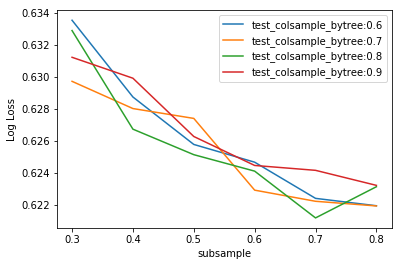

In [12]:
# summarize results
print("Best: %f using %s" % (-gsearch3_1.best_score_, gsearch3_1.best_params_))
test_means = gsearch3_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch3_1.cv_results_[ 'std_test_score' ]
train_means = gsearch3_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch3_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch3_1.cv_results_).to_csv('my_preds_subsampleh_colsample_bytree_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(colsample_bytree), len(subsample))
train_scores = np.array(train_means).reshape(len(colsample_bytree), len(subsample))

for i, value in enumerate(colsample_bytree):
    pyplot.plot(subsample, -test_scores[i], label= 'test_colsample_bytree:'   + str(value))
# for i, value in enumerate(colsample_bytree):
#     pyplot.plot(subsample, -train_scores[i], label= 'train_colsample_bytree:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'subsample' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'subsample_vs_colsample_bytree1.png' )

当前调参结果：  
最优colsample_bytree为0.8；   
最优subsample为0.7。